In [205]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [206]:
# 定义相对路径
file_data_dictionary = 'data/data_dictionary.csv'
file_summerOly_athletes = 'data/summerOly_athletes.csv'
file_summerOly_hosts = 'data/summerOly_hosts.csv'
file_summerOly_medal_counts = 'data/summerOly_medal_counts.csv'
file_summerOly_programs = 'data/summerOly_programs.csv'
# 读取表格
df_data_dictionary = pd.read_csv(file_data_dictionary, encoding='utf-8', encoding_errors='ignore')
df_summerOly_athletes = pd.read_csv(file_summerOly_athletes, encoding='utf-8', encoding_errors='ignore')
# 筛选并修改 'NOC' 列中 LBA 为 LBI
df_summerOly_athletes.loc[df_summerOly_athletes['NOC'] == 'LBA', 'NOC'] = 'LBI'
# 筛选并修改 'NOC' 列中 ROC 为 RUS
df_summerOly_athletes.loc[df_summerOly_athletes['NOC'] == 'ROC', 'NOC'] = 'RUS'
# 创建映射字典
replacement_map = {
    'North Macedonia': 'Macedonia',
    'Taiwan': 'Chinese Taipei',
    'FR Yugoslavia': 'Yugoslavia',
    'Formosa': 'Chinese Taipei',
    'Ceylon': 'Sri Lanka',
    'British West Indies': 'Great Britain'
}
# 使用 replace 方法替换
df_summerOly_athletes['Team'] = df_summerOly_athletes['Team'].replace(replacement_map)
df_summerOly_hosts = pd.read_csv(file_summerOly_hosts, encoding='utf-8', encoding_errors='ignore')
df_summerOly_medal_counts = pd.read_csv(file_summerOly_medal_counts, encoding='utf-8', encoding_errors='ignore')
df_summerOly_medal_counts['NOC'] = df_summerOly_medal_counts['NOC'].replace(replacement_map)
df_summerOly_programs = pd.read_csv(file_summerOly_programs, encoding='utf-8', encoding_errors='ignore')


In [207]:
athlete = df_summerOly_athletes[['Name', 'Sex', 'NOC', 'Year', 'Sport', 'Event', 'Medal']].drop_duplicates()
athlete

,Name,Sex,NOC,Year,Sport,Event,Medal
0,A Dijiang,M,CHN,1992,Basketball,Basketball Men's Basketball,No medal
1,A Lamusi,M,CHN,2012,Judo,Judo Men's Extra-Lightweight,No medal
2,Gunnar Aaby,M,DEN,1920,Football,Football Men's Football,No medal
3,Edgar Aabye,M,DEN,1900,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Cornelia (-strannood),F,NED,1932,Athletics,Athletics Women's 100 metres,No medal
...,...,...,...,...,...,...,...
252560,Sefora Ada,F,GEQ,2024,Athletics,Women's 100m,No medal
252561,Emanuela Liuzzi,F,ITA,2024,Wrestling,Women's Freestyle 50kg,No medal
252562,Isayah Boers,M,NED,2024,Athletics,4 x 400m Relay Mixed,Gold
252563,Kevin Staut,M,FRA,2024,Equestrian,Jumping Team,Bronze


In [208]:
country_df = pd.read_csv('ProcessedData/CountryType.csv').rename(columns={'Cluster': 'isGoodAt'})
# 合并数据
athlete_df = pd.merge(athlete, country_df, on="NOC", how="left").drop_duplicates()

athlete_df

,Name,Sex,NOC,Year,Sport,Event,Medal,isGoodAt
0,A Dijiang,M,CHN,1992,Basketball,Basketball Men's Basketball,No medal,1
1,A Lamusi,M,CHN,2012,Judo,Judo Men's Extra-Lightweight,No medal,1
2,Gunnar Aaby,M,DEN,1920,Football,Football Men's Football,No medal,0
3,Edgar Aabye,M,DEN,1900,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,0
4,Cornelia (-strannood),F,NED,1932,Athletics,Athletics Women's 100 metres,No medal,1
...,...,...,...,...,...,...,...,...
251081,Sefora Ada,F,GEQ,2024,Athletics,Women's 100m,No medal,0
251082,Emanuela Liuzzi,F,ITA,2024,Wrestling,Women's Freestyle 50kg,No medal,1
251083,Isayah Boers,M,NED,2024,Athletics,4 x 400m Relay Mixed,Gold,1
251084,Kevin Staut,M,FRA,2024,Equestrian,Jumping Team,Bronze,1


In [209]:
# Step 2: 定义基础评分
def calculate_raw_score(medal):
    if medal == "Gold":
        return 13
    elif medal == "Silver":
        return 9
    elif medal == "Bronze":
        return 5
    else:  # No medal
        return 1


athlete_df["Raw Score"] = athlete_df["Medal"].apply(calculate_raw_score)


# Step 3: 定义衰减函数
def calculate_participation_decay(participation_count, k1=0.1, t1=3):
    return 1 / (1 + np.exp(-k1 * (participation_count - t1)))


def calculate_time_decay(year, current_year=2016, k2=0.03, t2=2012):
    return 1 / (1 + np.exp(-k2 * (year - t2)))


# 统计参赛次数并计算衰减系数
participation_counts = athlete_df["Name"].value_counts()
athlete_df["Participation Count"] = athlete_df["Name"].map(participation_counts)
athlete_df["Participation Decay"] = athlete_df["Participation Count"].apply(calculate_participation_decay)
athlete_df["Time Decay"] = athlete_df["Year"].apply(lambda x: calculate_time_decay(x, current_year=2024))


# Step 4: 定义国家权重
def assign_country_weight(cluster, strong_weight=1.5, weak_weight=1.0):
    return strong_weight if cluster == 1 else weak_weight


athlete_df["Country Weight"] = athlete_df["isGoodAt"].apply(assign_country_weight)

# Step 5: 计算最终评分
athlete_df["Final Score"] = (
        athlete_df["Raw Score"] *
        athlete_df["Participation Decay"] *
        athlete_df["Time Decay"] *
        athlete_df["Country Weight"]
)

from sklearn.preprocessing import StandardScaler

# 标准化 Final Score
scaler = StandardScaler()
athlete_df["Standardized Score"] = scaler.fit_transform(
    athlete_df[["Final Score"]]
)
athlete_df

,Name,Sex,NOC,Year,Sport,Event,Medal,isGoodAt,Raw Score,Participation Count,Participation Decay,Time Decay,Country Weight,Final Score,Standardized Score
0,A Dijiang,M,CHN,1992,Basketball,Basketball Men's Basketball,No medal,1,1,1,0.450166,0.354344,1.5,0.239270,-0.266373
1,A Lamusi,M,CHN,2012,Judo,Judo Men's Extra-Lightweight,No medal,1,1,1,0.450166,0.500000,1.5,0.337625,-0.151250
2,Gunnar Aaby,M,DEN,1920,Football,Football Men's Football,No medal,0,1,1,0.450166,0.059524,1.0,0.026796,-0.515072
3,Edgar Aabye,M,DEN,1900,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,0,13,1,0.450166,0.033569,1.0,0.196452,-0.316490
4,Cornelia (-strannood),F,NED,1932,Athletics,Athletics Women's 100 metres,No medal,1,1,2,0.475021,0.083173,1.5,0.059263,-0.477069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251081,Sefora Ada,F,GEQ,2024,Athletics,Women's 100m,No medal,0,1,1,0.450166,0.589040,1.0,0.265166,-0.236062
251082,Emanuela Liuzzi,F,ITA,2024,Wrestling,Women's Freestyle 50kg,No medal,1,1,1,0.450166,0.589040,1.5,0.397749,-0.080875
251083,Isayah Boers,M,NED,2024,Athletics,4 x 400m Relay Mixed,Gold,1,13,1,0.450166,0.589040,1.5,5.170737,5.505864
251084,Kevin Staut,M,FRA,2024,Equestrian,Jumping Team,Bronze,1,5,5,0.549834,0.589040,1.5,2.429058,2.296755


In [210]:
# Group by Name, NOC, Sex, and Sport, and sum the Final Score
athlete_score_summary = athlete_df.groupby(["Name", "NOC", "Sex", "Sport"], as_index=False)["Final Score"].sum()
# 查看汇总后的结果
athlete_score_summary = athlete_score_summary.drop_duplicates()
# 使用分位数对 Final Score 进行截断处理
lower_quantile = athlete_score_summary["Final Score"].quantile(0.01)
upper_quantile = athlete_score_summary["Final Score"].quantile(0.99)
print(lower_quantile, upper_quantile)
strange1 = athlete_score_summary[(athlete_score_summary["Final Score"] < lower_quantile)]
strange1['Cluster'] = 0
strange2 = athlete_score_summary[(athlete_score_summary["Final Score"] > upper_quantile)]
strange2['Cluster'] = 1
athlete_score_summary = athlete_score_summary[
    (athlete_score_summary["Final Score"] >= lower_quantile) &
    (athlete_score_summary["Final Score"] <= upper_quantile)
]

athlete_score_summary

0.026795845894150835 8.961962118376693


C:\Users\ZS\AppData\Local\Temp\ipykernel_27484\2454358056.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strange1['Cluster'] = 0
C:\Users\ZS\AppData\Local\Temp\ipykernel_27484\2454358056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strange2['Cluster'] = 1


,Name,NOC,Sex,Sport,Final Score
0,(jr) Larocca,ARG,M,Equestrian,0.265166
1,. Chadalavada,IND,F,Fencing,0.251964
2,. Deni,INA,M,Weightlifting,0.251964
3,671,CHN,F,Breaking,1.988745
4,A Alayed,KSA,F,Swimming,0.265166
...,...,...,...,...,...
135563,zge Emberci,TUR,F,Volleyball,0.225083
135564,zlem Kaya,TUR,F,Athletics,0.489254
135565,zman Graud,TUR,M,Shooting,0.104202
135566,zzet Nce,TUR,M,Weightlifting,0.432422


C:\Users\ZS\anaconda3\envs\2025MCM\lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\ZS\anaconda3\envs\2025MCM\lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\ZS\anaconda3\envs\2025MCM\lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THRE

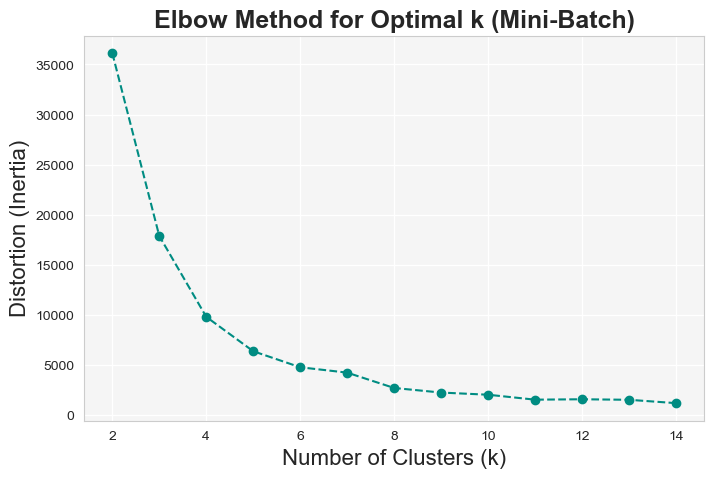

In [211]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 标准化 Final Score
scaler = StandardScaler()
athlete_score_summary["Standardized Score"] = scaler.fit_transform(
    athlete_score_summary[["Final Score"]]
)

# 使用 Mini-Batch K-Means 和减少范围
distortions = []
K = range(2, 15)  # 测试 2 到 5 个聚类数

for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    kmeans.fit(athlete_score_summary[["Standardized Score"]])
    distortions.append(kmeans.inertia_)

# 绘制肘部法则曲线
# import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax = plt.gca()  # 获取当前轴
ax.set_facecolor('#f5f5f5')  # 设置灰色背景颜色

plt.plot(K, distortions, marker='o', linestyle='--', color="#008c82")  # 设置折线图
plt.xlabel('Number of Clusters (k)', fontsize=16)
plt.ylabel('Distortion (Inertia)', fontsize=16)
plt.title('Elbow Method for Optimal k (Mini-Batch)', fontsize=18, fontweight='bold')
plt.grid(color='white', linestyle='-', linewidth=1)  # 设置网格样式

plt.show()


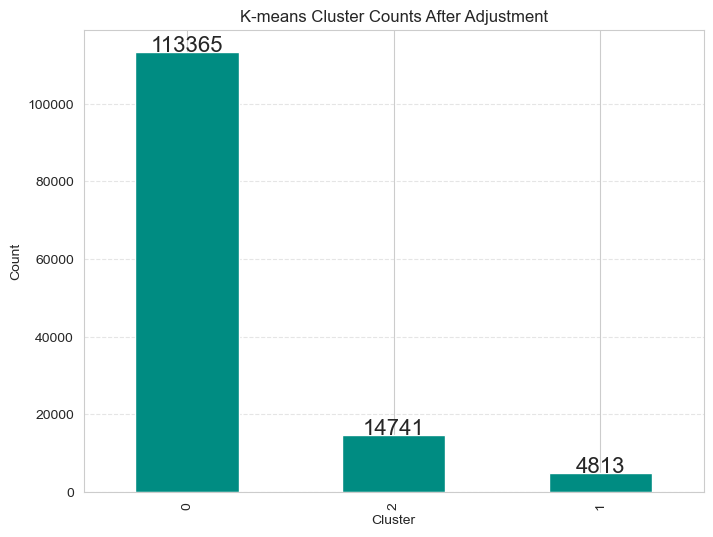

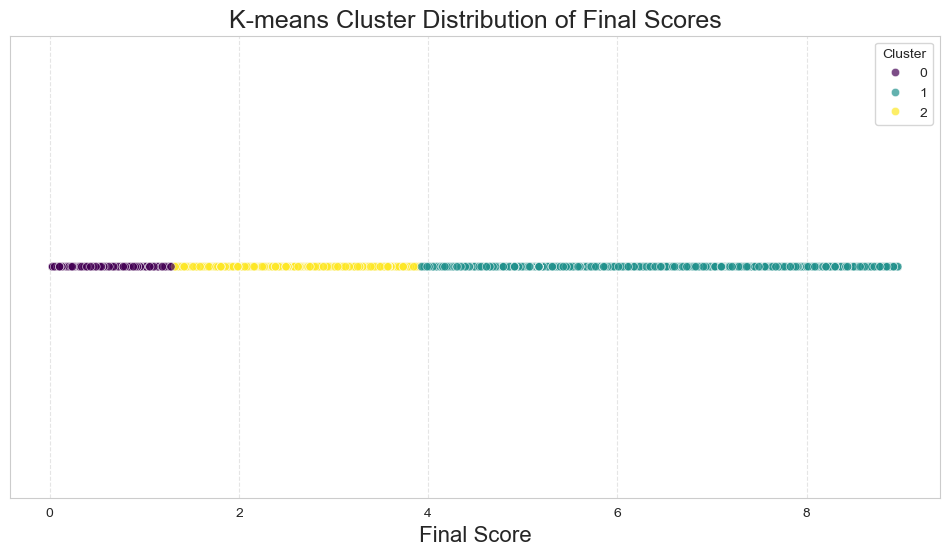

In [212]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 设置最优的 k 值并进行 K-means 聚类
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
athlete_score_summary["Cluster"] = kmeans.fit_predict(
    athlete_score_summary[["Standardized Score"]]
)

# 统计每个 Cluster 的数量
cluster_counts = athlete_score_summary["Cluster"].value_counts()

# 绘制柱状图
plt.figure(figsize=(8, 6))
bar = cluster_counts.plot(kind="bar", title="K-means Cluster Counts After Adjustment", color="#008c82")
plt.xlabel("Cluster")
plt.ylabel("Count")

# 在柱状图上显示具体的计数值
for i, count in enumerate(cluster_counts):
    plt.text(i, count + 100, str(count), ha='center', fontsize=16)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# 绘制散点图
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=athlete_score_summary["Final Score"],
    y=[0] * len(athlete_score_summary),  # 固定 y 为 0，表示一维分布
    hue=athlete_score_summary["Cluster"],  # 使用 Cluster 进行分类着色
    palette="viridis",
    alpha=0.7  # 设置透明度
)

# 图形美化
plt.title("K-means Cluster Distribution of Final Scores", fontsize=18)
plt.xlabel("Final Score", fontsize=16)
plt.ylabel("")
plt.yticks([])  # 隐藏 y 轴刻度
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.legend(title="Cluster", loc="upper right")
plt.show()


In [213]:
# from sklearn.mixture import GaussianMixture
# 
# # 使用 GMM 进行聚类
# gmm = GaussianMixture(n_components=3, random_state=42)
# athlete_score_summary["Cluster"] = gmm.fit_predict(
#     athlete_score_summary[["Final Score"]]
# )
# # 统计每个 Cluster 的数量
# cluster_counts = athlete_score_summary["Cluster"].value_counts()
# print(cluster_counts)
# 
# # 可视化分布
# cluster_counts.plot(kind="bar", title="GMM Cluster Counts After Adjustment", color="skyblue")
# plt.xlabel("Cluster")
# plt.ylabel("Count")
# # plt.show()
# 
# import matplotlib.pyplot as plt
# import seaborn as sns
# 
# # 设置图形大小
# plt.figure(figsize=(12, 6))
# 
# # 绘制散点图，每个点的颜色代表 Cluster
# sns.scatterplot(
#     x=athlete_score_summary["Final Score"],
#     y=[0] * len(athlete_score_summary),  # 固定 y 为 0，表示一维
#     hue=athlete_score_summary["Cluster"],  # 使用 Cluster 进行着色
#     palette="viridis",
#     alpha=0.7  # 设置透明度
# )
# 
# # 图形美化
# plt.title("GMM Cluster Distribution of Final Scores", fontsize=14)
# plt.xlabel("Final Score", fontsize=12)
# plt.ylabel("")
# plt.yticks([])  # 隐藏 y 轴刻度
# plt.grid(axis="x", linestyle="--", alpha=0.5)
# plt.legend(title="Cluster", loc="upper right")
# # plt.show()

In [214]:
strange1 = strange1[['Name', 'NOC', 'Sex', 'Sport', 'Final Score', 'Cluster']]
strange2 = strange2[['Name', 'NOC', 'Sex', 'Sport', 'Final Score', 'Cluster']]

In [215]:
athlete_score_summary = athlete_score_summary[['Name', 'NOC', 'Sex', 'Sport', 'Final Score', 'Cluster']]
athlete_score_summary = pd.concat([athlete_score_summary, strange1])
athlete_score_summary = pd.concat([athlete_score_summary, strange2]).drop_duplicates()
# athlete_score_summary = athlete_score_summary.to_csv('ProcessedData/kMeansAthleteClusterSummary.csv')
athlete_score_summary

,Name,NOC,Sex,Sport,Final Score,Cluster
0,(jr) Larocca,ARG,M,Equestrian,0.265166,0
1,. Chadalavada,IND,F,Fencing,0.251964,0
2,. Deni,INA,M,Weightlifting,0.251964,0
3,671,CHN,F,Breaking,1.988745,2
4,A Alayed,KSA,F,Swimming,0.265166,0
...,...,...,...,...,...,...
135160,ron Szilgyi,HUN,M,Fencing,11.284116,1
135404,va Risztov,HUN,F,Swimming,12.385095,1
135515,van Roy,NED,M,Cycling Track,12.687606,1
135524,van Sharon,NED,F,Marathon Swimming,9.521211,1
